In [1]:
!pip install q numpy==1.17

In [0]:
import re

import os
from os import listdir
from os.path import isfile, join

import torch
from torch.utils.data import Dataset

import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import numpy as np

from PIL import Image

import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt

In [3]:
!wget "http://www-sop.inria.fr/members/Alexis.Joly/BelgaLogos/qset3_internal_and_local.gt"
!mv qset3_internal_and_local.gt gt 
gt_file = "gt"

!wget "http://www-sop.inria.fr/members/Alexis.Joly/BelgaLogos/images.tar.gz"
!tar -xzf images.tar.gz
images_folder = "images/"

print('Number of files in the images folder', len(listdir(images_folder)))

--2020-03-20 11:33:55--  http://www-sop.inria.fr/members/Alexis.Joly/BelgaLogos/qset3_internal_and_local.gt
Resolving www-sop.inria.fr (www-sop.inria.fr)... 138.96.0.39
Connecting to www-sop.inria.fr (www-sop.inria.fr)|138.96.0.39|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 542926 (530K) [text/plain]
Saving to: ‘qset3_internal_and_local.gt’

qset3_internal_and_ 100%[===================>] 530.20K   118KB/s    in 4.5s    

2020-03-20 11:34:00 (118 KB/s) - ‘qset3_internal_and_local.gt’ saved [542926/542926]

--2020-03-20 11:34:03--  http://www-sop.inria.fr/members/Alexis.Joly/BelgaLogos/images.tar.gz
Resolving www-sop.inria.fr (www-sop.inria.fr)... 138.96.0.39
Connecting to www-sop.inria.fr (www-sop.inria.fr)|138.96.0.39|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1077036878 (1.0G) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>]   1.00G   335KB/s    in 55m 9s  

2020-03-20 12:29:13 (3

In [4]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 7217 (delta 1), reused 5 (delta 0), pack-reused 7207
Receiving objects: 100% (7217/7217), 9.91 MiB | 6.50 MiB/s, done.
Resolving deltas: 100% (4876/4876), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
device = torch.device('cuda:0')

In [0]:
gt_pattern = re.compile(r'^(?P<box_num>[\w-]+)\s(?P<label>[\w-]+)\s(?P<file_name>[\w\.]+)\s(?P<logo>\w+)\s(?P<num>\w+)\s(?P<xmin>\w+)\s(?P<ymin>\w+)\s(?P<xmax>\w+)\s(?P<ymax>\w+)$')

class LogoDetectionDataset(Dataset):
  
  def __init__(self, image_folder, gt_file, transform=None):
    self.image_folder = image_folder
    self.gt_file = gt_file
    self.transform = transform
    self.boxes = {}
    with open(gt_file) as file:
      lines = file.readlines()
      for line in lines:
        match = gt_pattern.match(line)
        if not match:
          display(line)
          continue
        file_name = match.group('file_name')
        xmin = int(match.group('xmin'))
        ymin = int(match.group('ymin'))
        xmax = int(match.group('xmax'))
        ymax = int(match.group('ymax'))
        if (xmin > xmax):
          x = xmin
          xmin = xmax
          xmax = x
        if (ymin > ymax):
          y = ymin
          ymin = ymax
          ymax = y
        if (file_name in self.boxes.keys()):
          self.boxes[file_name].append((xmin, ymin, xmax, ymax))
        else:
          self.boxes[file_name] = [(xmin, ymin, xmax, ymax)]
    self.keys = list(self.boxes.keys())
  
  def __len__(self):
    return len(self.keys)

  def __getitem__(self, index): 
    image_name = self.keys[index]

    image_path = os.path.join(self.image_folder, image_name)

    img = Image.open(image_path).convert('RGB')
    target = {}
    boxes = self.boxes[image_name]
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    num_objs = len(boxes)
    labels = torch.ones((num_objs), dtype=torch.int64)
    img_id = torch.tensor([index])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = img_id
    target['area'] = area
    target['iscrowd'] = iscrowd

    if self.transform:
      img, target = self.transform(img, target)

    return img, target

In [14]:
from engine import train_one_epoch, evaluate
import utils
import transforms

tfs = transforms.Compose([
                          transforms.ToTensor(),                       
                       ])

num_classes = 2
batch_size = 4

dataset = LogoDetectionDataset(images_folder, gt_file, transform=tfs)
orig_dataset = LogoDetectionDataset(images_folder, gt_file)

validation_size = .3

data_size = len(dataset)
split = int(np.floor(validation_size * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, collate_fn=utils.collate_fn)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, 
                                         sampler=val_sampler, collate_fn=utils.collate_fn)

'Peugeot_0007    Peugeot 07585235.jpg    logo    1       29      217     84      277\n'

'StellaArtois_0028       StellaArtois    07647985.jpg    logo    1       137\t215\t231\t274\n'

'Peugeot_0007    Peugeot 07585235.jpg    logo    1       29      217     84      277\n'

'StellaArtois_0028       StellaArtois    07647985.jpg    logo    1       137\t215\t231\t274\n'

In [0]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [16]:
num_epochs = 10

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
  lr_scheduler.step()
  evaluate(model, val_loader, device=device)

Epoch: [0]  [  0/199]  eta: 0:03:20  lr: 0.000030  loss: 1.2618 (1.2618)  loss_classifier: 0.6545 (0.6545)  loss_box_reg: 0.0240 (0.0240)  loss_objectness: 0.5436 (0.5436)  loss_rpn_box_reg: 0.0396 (0.0396)  time: 1.0072  data: 0.0764  max mem: 11450
Epoch: [0]  [ 10/199]  eta: 0:02:55  lr: 0.000282  loss: 1.2618 (1.4017)  loss_classifier: 0.5306 (0.5010)  loss_box_reg: 0.0240 (0.0221)  loss_objectness: 0.5675 (0.7939)  loss_rpn_box_reg: 0.0396 (0.0847)  time: 0.9274  data: 0.0575  max mem: 11881
Epoch: [0]  [ 20/199]  eta: 0:02:42  lr: 0.000535  loss: 0.8924 (1.0396)  loss_classifier: 0.2508 (0.3318)  loss_box_reg: 0.0265 (0.0343)  loss_objectness: 0.3346 (0.5703)  loss_rpn_box_reg: 0.0435 (0.1032)  time: 0.9001  data: 0.0552  max mem: 12401
Epoch: [0]  [ 30/199]  eta: 0:02:33  lr: 0.000787  loss: 0.5501 (0.8754)  loss_classifier: 0.1354 (0.2877)  loss_box_reg: 0.0428 (0.0499)  loss_objectness: 0.2040 (0.4446)  loss_rpn_box_reg: 0.0366 (0.0931)  time: 0.8933  data: 0.0567  max mem: 12

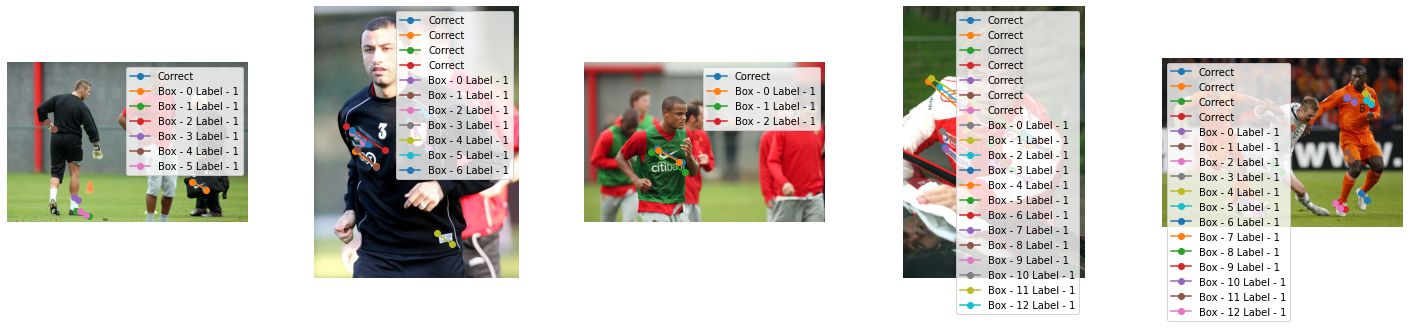

In [20]:
model.eval()
count = 5
plt.figure(figsize=(count * 5,5))
for i_step, (images, targets) in enumerate(val_loader):
  if i_step == count:
    break
    
  val_image = list(image.to(device) for image in images)
  prediction = model(val_image)[0]

  image_id = int(targets[0]['image_id'])
  image, target = orig_dataset[image_id]

  boxes = target['boxes']
  predict_boxes = prediction['boxes']
  predict_labels = prediction['labels']

  plt.subplot(1, count, i_step + 1)
  plt.imshow(image)

  for box in boxes:
    x = [box[0], box[2]]
    y = [box[1], box[3]]
    plt.plot(x, y, marker = 'o', label='Correct')
  for i, box in enumerate(predict_boxes):
    x = [box[0], box[2]]
    y = [box[1], box[3]]
    predict_label = int(predict_labels[i])
    view_label = 'Box - %d Label - %d' % (i, predict_label)
    plt.plot(x, y, marker = 'o', label=view_label)

  plt.grid(False)
  plt.axis('off')
  plt.legend()  